<a href="https://colab.research.google.com/github/abidlifiras/QA_LLM/blob/master/mdeberta_v3_base_squad2_first_try.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Notebook — Step 1: Dataset Loading & Initial Exploration**

In [ ]:
!git clone https://github.com/abidlifiras/QA_LLM.git

Cloning into 'QA_LLM'...
remote: Enumerating objects: 13, done.
remote: Counting objects: 100% (13/13), done.
remote: Compressing objects: 100% (11/11), done.
remote: Total 13 (delta 2), reused 6 (delta 1), pack-reused 0 (from 0)
Receiving objects: 100% (13/13), 555.69 KiB | 4.31 MiB/s, done.
Resolving deltas: 100% (2/2), done.


In [ ]:
!pip install transformers==4.17
!pip install transformers datasets evaluate

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.9/67.9 kB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 41.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 897.5/897.5 kB 32.6 MB/s eta 0:00:00
  Attempting uninstall: transformers
    Found existing installation: transformers 4.52.3
    Uninstalling transformers-4.52.3:
      Successfully uninstalled transformers-4.52.3
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.5/491.5 kB 10.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 7.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 10.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 kB 16.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 14.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 17.3 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.5.1
    Uninstalling fss

In [ ]:
# Install dependencies (run once)


import json
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from transformers import AutoTokenizer, AutoModelForMultipleChoice, Trainer, TrainingArguments
import torch
from datasets import Dataset
import numpy as np
import evaluate


**Step 2: Dataset KPIs and Distribution Plots**

Dataset sizes:
Train: 2171 (69.92%)
Dev: 312 (10.05%)
Test: 622 (20.03%)

Train KPIs:
- Unique subjects: 1
- Avg. number of answer options: 5.00
- Avg. number of correct answers: 2.38
Dev KPIs:
- Unique subjects: 1
- Avg. number of answer options: 5.00
- Avg. number of correct answers: 1.91
Test KPIs:
- Unique subjects: 1
- Avg. number of answer options: 5.00
- Avg. number of correct answers: 1.92


<ipython-input-7-27378bb3334e>:37: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=['Train', 'Dev', 'Test'],


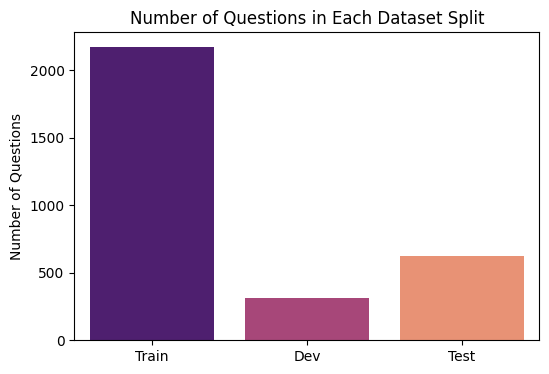

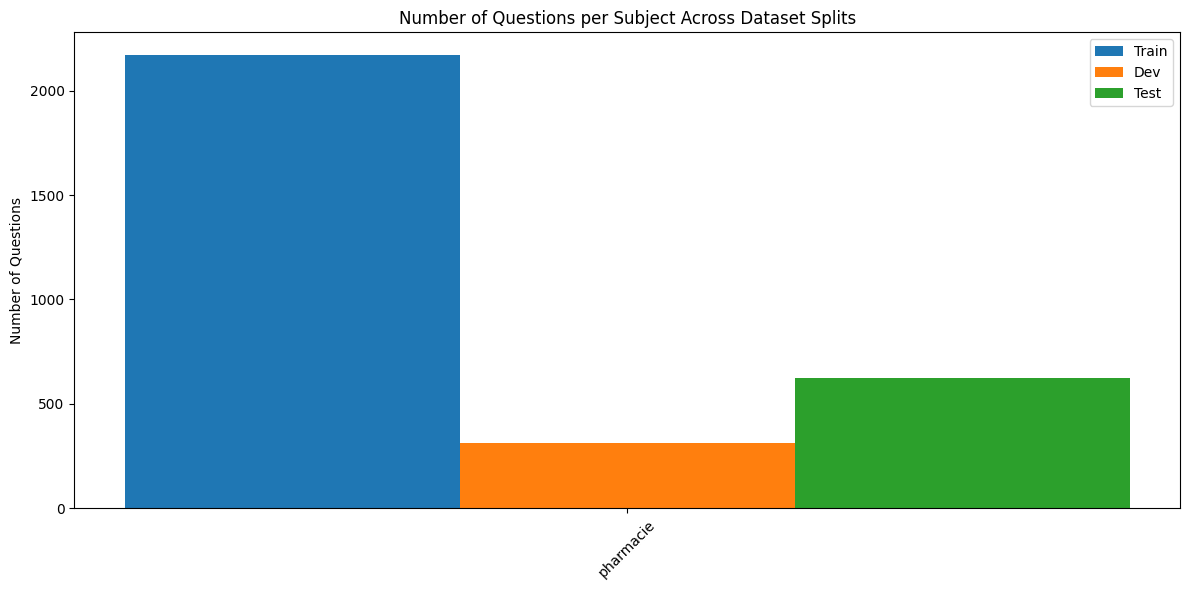

In [ ]:
# Load datasets
df_train = pd.read_json('QA_LLM/dataset/train.json')
df_dev = pd.read_json('QA_LLM/dataset/dev.json')
df_test = pd.read_json('QA_LLM/dataset/test.json')

# Function to compute KPIs for a dataset
def compute_kpis(df):
    return {
        'total_questions': len(df),
        'unique_subjects': df['subject_name'].nunique(),
        'avg_num_answers': df['answers'].apply(len).mean(),
        'avg_correct_answers': df['nbr_correct_answers'].mean()
    }

# Compute KPIs for each set
train_kpis = compute_kpis(df_train)
dev_kpis = compute_kpis(df_dev)
test_kpis = compute_kpis(df_test)

# Print dataset sizes and their relative percentages
total_all = train_kpis['total_questions'] + dev_kpis['total_questions'] + test_kpis['total_questions']

print("Dataset sizes:")
print(f"Train: {train_kpis['total_questions']} ({train_kpis['total_questions']/total_all*100:.2f}%)")
print(f"Dev: {dev_kpis['total_questions']} ({dev_kpis['total_questions']/total_all*100:.2f}%)")
print(f"Test: {test_kpis['total_questions']} ({test_kpis['total_questions']/total_all*100:.2f}%)\n")

# Print some KPIs per dataset
for split_name, kpis in zip(['Train', 'Dev', 'Test'], [train_kpis, dev_kpis, test_kpis]):
    print(f"{split_name} KPIs:")
    print(f"- Unique subjects: {kpis['unique_subjects']}")
    print(f"- Avg. number of answer options: {kpis['avg_num_answers']:.2f}")
    print(f"- Avg. number of correct answers: {kpis['avg_correct_answers']:.2f}")

# Visual comparison of dataset sizes
plt.figure(figsize=(6,4))
sns.barplot(x=['Train', 'Dev', 'Test'],
            y=[train_kpis['total_questions'], dev_kpis['total_questions'], test_kpis['total_questions']],
            palette='magma')
plt.title('Number of Questions in Each Dataset Split')
plt.ylabel('Number of Questions')
plt.show()

# Compare subject coverage between datasets (plot number of questions per subject for each)
plt.figure(figsize=(12,6))
subjects = sorted(set(df_train['subject_name']).union(df_dev['subject_name']).union(df_test['subject_name']))

train_counts = df_train['subject_name'].value_counts().reindex(subjects, fill_value=0)
dev_counts = df_dev['subject_name'].value_counts().reindex(subjects, fill_value=0)
test_counts = df_test['subject_name'].value_counts().reindex(subjects, fill_value=0)

x = range(len(subjects))
width = 0.25

plt.bar([i - width for i in x], train_counts, width=width, label='Train')
plt.bar(x, dev_counts, width=width, label='Dev')
plt.bar([i + width for i in x], test_counts, width=width, label='Test')

plt.xticks(x, subjects, rotation=45)
plt.ylabel('Number of Questions')
plt.title('Number of Questions per Subject Across Dataset Splits')
plt.legend()
plt.tight_layout()
plt.show()


**Step3: fine-tuning DistilBERT for Multiple Choice**

In [ ]:
import transformers
print(transformers.__version__)


4.17.0


In [ ]:
# Convert letter labels to index
letter_to_index = {"a": 0, "b": 1, "c": 2, "d": 3, "e": 4}

# Format function
def format_dataframe(df):
    samples = []
    for _, row in df.iterrows():
        answers = [row["answers"].get(k, "") for k in ["a", "b", "c", "d", "e"]]
        correct_letter = row["correct_answers"][0].lower()
        label = letter_to_index.get(correct_letter, -1)
        if label != -1:
            samples.append({
                "question": row["question"],
                "choices": answers,
                "label": label,
                "subject": row.get("subject_name", "unknown")
            })
    return Dataset.from_list(samples)

# Create Dataset objects
dataset_train = format_dataframe(df_train)
dataset_dev = format_dataframe(df_dev)
dataset_test = format_dataframe(df_test)


In [ ]:
# Load tokenizer
model_checkpoint = "bert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)

# Tokenization function
def preprocess(example):
    question = example["question"]
    choices = example["choices"]
    inputs = tokenizer(
        [question] * len(choices),
        choices,
        truncation=True,
        padding="max_length",
        max_length=256,
        return_tensors="pt"
    )
    return {
        "input_ids": inputs["input_ids"].numpy(),
        "attention_mask": inputs["attention_mask"].numpy(),
        "label": example["label"]
    }

# Apply to datasets
encoded_train = dataset_train.map(preprocess)
encoded_dev = dataset_dev.map(preprocess)


Downloading:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/455k [00:00<?, ?B/s]

Map:   0%|          | 0/2171 [00:00<?, ? examples/s]

Map:   0%|          | 0/312 [00:00<?, ? examples/s]

In [ ]:
# Load model for multiple choice
model = AutoModelForMultipleChoice.from_pretrained(model_checkpoint)
# Define training arguments
training_args = TrainingArguments(
    output_dir="./bert-base-uncased",
    evaluation_strategy="epoch",
    save_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=4,
    per_device_eval_batch_size=4,
    num_train_epochs=3,
    weight_decay=0.01,
    logging_dir="./logs",
    load_best_model_at_end=True,
    save_total_limit=1,
    push_to_hub=False
)


Downloading:   0%|          | 0.00/420M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForMultipleChoice: ['cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForMultipleChoice from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMultipleChoice from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForMultipleChoice were not initialized from the model checkpoint at bert-base-uncased and are newly

In [ ]:
# Accuracy metric
accuracy = evaluate.load("accuracy")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=1)
    return accuracy.compute(predictions=predictions, references=labels)


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [ ]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=encoded_train,
    eval_dataset=encoded_dev,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)

trainer.train()


The following columns in the training set  don't have a corresponding argument in `BertForMultipleChoice.forward` and have been ignored: question, choices, subject. If question, choices, subject are not expected by `BertForMultipleChoice.forward`,  you can safely ignore this message.
/usr/local/lib/python3.11/dist-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 2171
  Num Epochs = 3
  Instantaneous batch size per device = 4
  Total train batch size (w. parallel, distributed & accumulation) = 4
  Gradient Accumulation steps = 1
  Total optimization steps = 1629


Epoch,Training Loss,Validation Loss,Accuracy
1,1.612700,1.607814,0.246795
2,1.589800,1.602072,0.237179
3,1.488900,1.706029,0.246795


The following columns in the evaluation set  don't have a corresponding argument in `BertForMultipleChoice.forward` and have been ignored: question, choices, subject. If question, choices, subject are not expected by `BertForMultipleChoice.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 312
  Batch size = 4
Saving model checkpoint to ./mcq_deberta/checkpoint-543
Configuration saved in ./mcq_deberta/checkpoint-543/config.json
Model weights saved in ./mcq_deberta/checkpoint-543/pytorch_model.bin
tokenizer config file saved in ./mcq_deberta/checkpoint-543/tokenizer_config.json
Special tokens file saved in ./mcq_deberta/checkpoint-543/special_tokens_map.json
The following columns in the evaluation set  don't have a corresponding argument in `BertForMultipleChoice.forward` and have been ignored: question, choices, subject. If question, choices, subject are not expected by `BertForMultipleChoice.forward`,  you can safely ignore this message.
***

TrainOutput(global_step=1629, training_loss=1.5509219699435763, metrics={'train_runtime': 530.896, 'train_samples_per_second': 12.268, 'train_steps_per_second': 3.068, 'total_flos': 4284067293642240.0, 'train_loss': 1.5509219699435763, 'epoch': 3.0})

In [ ]:
# Save model locally
model_dir = "./saved_bert_base_uncased"
trainer.save_model(model_dir)
tokenizer.save_pretrained(model_dir)

# Optionally zip the folder for download
import shutil
shutil.make_archive("bert_base_uncased_model", 'zip', model_dir)


Saving model checkpoint to ./saved_bert_base_uncased
Configuration saved in ./saved_bert_base_uncased/config.json
Model weights saved in ./saved_bert_base_uncased/pytorch_model.bin
tokenizer config file saved in ./saved_bert_base_uncased/tokenizer_config.json
Special tokens file saved in ./saved_bert_base_uncased/special_tokens_map.json
tokenizer config file saved in ./saved_bert_base_uncased/tokenizer_config.json
Special tokens file saved in ./saved_bert_base_uncased/special_tokens_map.json


'/content/bert_base_uncased_model.zip'

In [ ]:
# 🔧 Convert letter to index
letter_to_index = {"a": 0, "b": 1, "c": 2, "d": 3, "e": 4}

def format_dataframe(df):
    samples = []
    for _, row in df.iterrows():
        choices = [row["answers"].get(k, "") for k in ["a", "b", "c", "d", "e"]]
        label = letter_to_index.get(row["correct_answers"][0].lower(), -1)
        if label != -1:
            samples.append({
                "question": row["question"],
                "choices": choices,
                "label": label,
                "subject": row.get("subject_name", "unknown")
            })
    return Dataset.from_list(samples)

# 🧹 Format the data
dataset_train = format_dataframe(df_train)
dataset_dev = format_dataframe(df_dev)

# 🧠 Model and Tokenizer
model_checkpoint = "bert-base-uncased"  # You can try: "roberta-base" or "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)

# ✂️ Correct input formatting: [CLS] question [SEP] option [SEP]
def preprocess(example):
    input_texts = [f"{example['question']} [SEP] {choice}" for choice in example["choices"]]
    tokenized = tokenizer(
        input_texts,
        padding="max_length",
        truncation=True,
        max_length=256,
        return_tensors="pt"
    )
    return {
        "input_ids": tokenized["input_ids"].numpy(),
        "attention_mask": tokenized["attention_mask"].numpy(),
        "label": example["label"]
    }

# 🔁 Apply to datasets
encoded_train = dataset_train.map(preprocess)
encoded_dev = dataset_dev.map(preprocess)

# 🧠 Load model
model = AutoModelForMultipleChoice.from_pretrained(model_checkpoint)

# 🧪 Metric
accuracy = evaluate.load("accuracy")
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=1)
    return accuracy.compute(predictions=preds, references=labels)

# ⚙️ Training arguments
training_args = TrainingArguments(
    output_dir="./mcq_model",
    evaluation_strategy="epoch",
    save_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=4,
    per_device_eval_batch_size=4,
    num_train_epochs=5,
    weight_decay=0.01,
    load_best_model_at_end=True,
    save_total_limit=1,
    logging_dir="./logs",
)

# 🏋️ Fine-tune
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=encoded_train,
    eval_dataset=encoded_dev,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)
trainer.train()

# 💾 Save model and tokenizer locally
model.save_pretrained("saved_mcq_model")
tokenizer.save_pretrained("saved_mcq_model")

# 🗜️ Zip for download or web deployment
shutil.make_archive("bert_mcq_model", 'zip', "saved_mcq_model")


loading configuration file https://huggingface.co/bert-base-uncased/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/3c61d016573b14f7f008c02c4e51a366c67ab274726fe2910691e2a761acf43e.37395cee442ab11005bcd270f3c34464dc1704b715b5d7d52b1a461abe3b9e4e
Model config BertConfig {
  "_name_or_path": "bert-base-uncased",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.17.0",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

loading file https://huggingface.co/bert-base-uncased/resolve/ma

Map:   0%|          | 0/2171 [00:00<?, ? examples/s]

Map:   0%|          | 0/312 [00:00<?, ? examples/s]

loading configuration file https://huggingface.co/bert-base-uncased/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/3c61d016573b14f7f008c02c4e51a366c67ab274726fe2910691e2a761acf43e.37395cee442ab11005bcd270f3c34464dc1704b715b5d7d52b1a461abe3b9e4e
Model config BertConfig {
  "_name_or_path": "bert-base-uncased",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.17.0",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

loading weights file https://huggingface.co/bert-base-uncased/re

Epoch,Training Loss,Validation Loss,Accuracy
1,1.614200,1.609375,0.240385
2,1.611500,1.609379,0.221154
3,1.619200,1.608933,0.227564
4,1.607400,1.614575,0.201923
5,1.559700,1.637571,0.205128


The following columns in the evaluation set  don't have a corresponding argument in `BertForMultipleChoice.forward` and have been ignored: question, choices, subject. If question, choices, subject are not expected by `BertForMultipleChoice.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 312
  Batch size = 4
Saving model checkpoint to ./mcq_model/checkpoint-543
Configuration saved in ./mcq_model/checkpoint-543/config.json
Model weights saved in ./mcq_model/checkpoint-543/pytorch_model.bin
tokenizer config file saved in ./mcq_model/checkpoint-543/tokenizer_config.json
Special tokens file saved in ./mcq_model/checkpoint-543/special_tokens_map.json
The following columns in the evaluation set  don't have a corresponding argument in `BertForMultipleChoice.forward` and have been ignored: question, choices, subject. If question, choices, subject are not expected by `BertForMultipleChoice.forward`,  you can safely ignore this message.
***** Running

'/content/bert_mcq_model.zip'

In [ ]:
# Evaluate on dev
results = trainer.evaluate()
print("Base model evaluation:", results)


The following columns in the evaluation set  don't have a corresponding argument in `BertForMultipleChoice.forward` and have been ignored: question, choices, subject. If question, choices, subject are not expected by `BertForMultipleChoice.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 312
  Batch size = 4


Base model evaluation: {'eval_loss': 1.6089330911636353, 'eval_accuracy': 0.22756410256410256, 'eval_runtime': 10.0504, 'eval_samples_per_second': 31.044, 'eval_steps_per_second': 7.761, 'epoch': 5.0}
